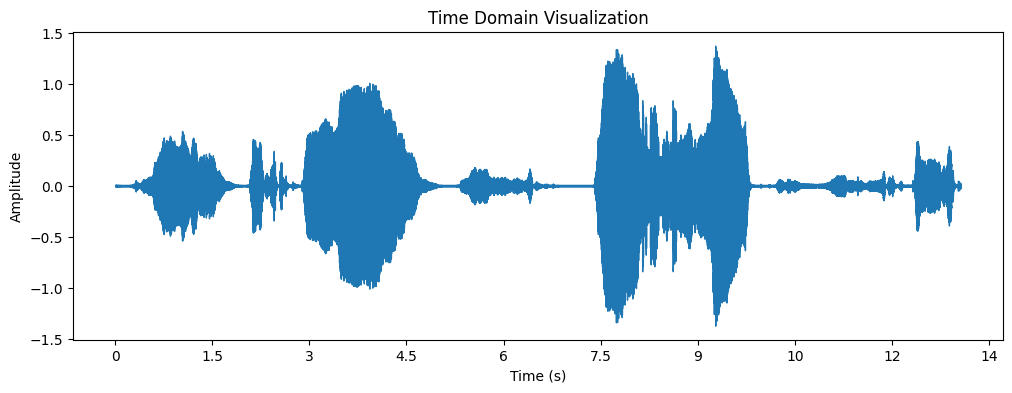

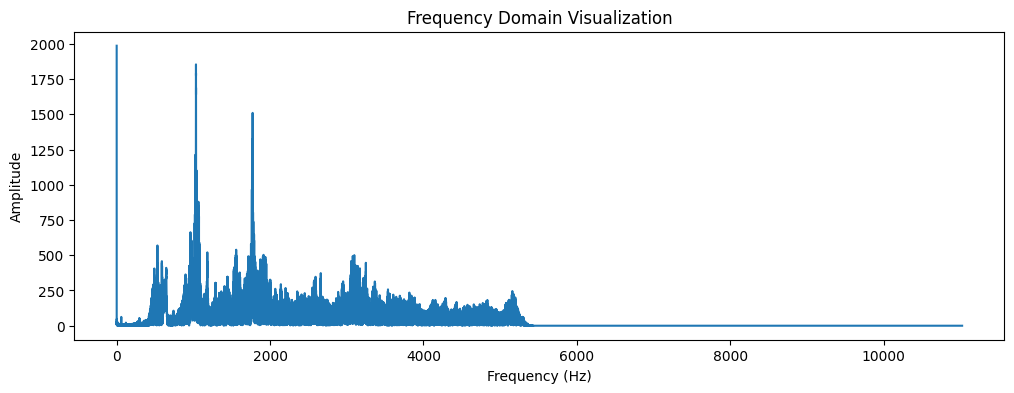

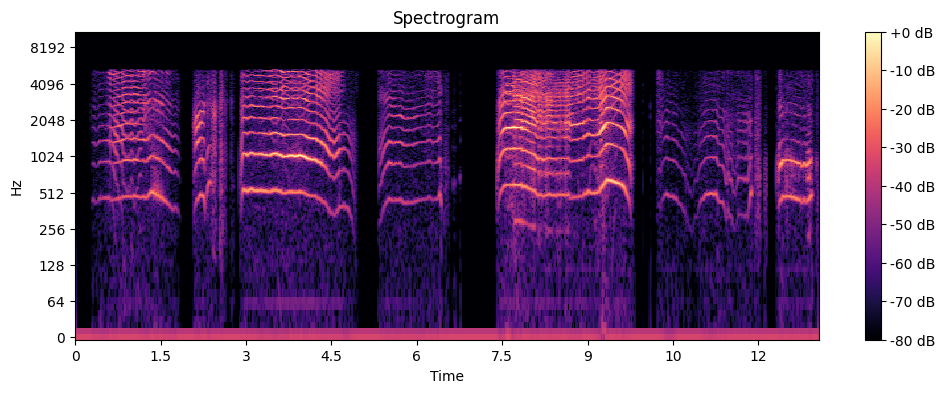

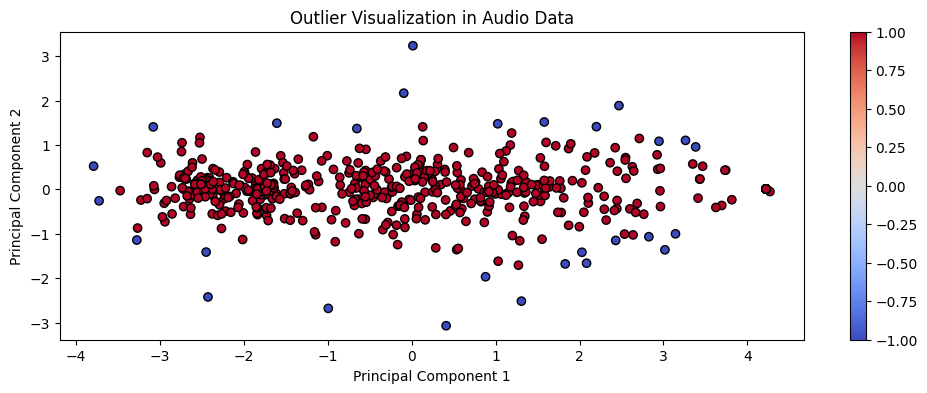

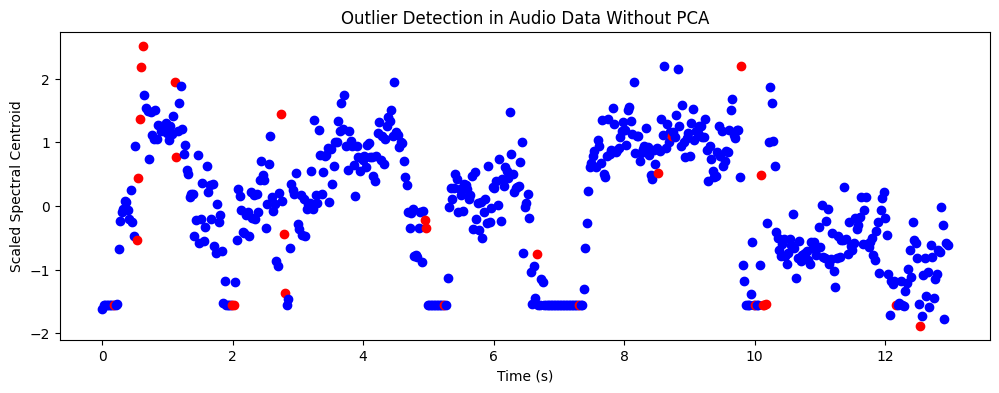

In [ ]:
# Univariate analysis

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

audio_path = 'baby_cry.wav'
y, sr = librosa.load(audio_path)

# Time Domain Visualization
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Time Domain Visualization')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Frequency Domain Visualization using FFT
fft_spectrum = np.fft.rfft(y)
fft_frequency = np.fft.rfftfreq(len(y), d=1/sr)
plt.figure(figsize=(12, 4))
plt.plot(fft_frequency, np.abs(fft_spectrum))
plt.title('Frequency Domain Visualization')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

#Spectrogram
plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

#Framing of Audio Signals
frame_length = 2048
hop_length = 512
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).T

#Computation of spectral centroid
spectral_centroids = np.array([librosa.feature.spectral_centroid(y=frame, sr=sr).flatten() for frame in frames])

#Scaling
scaler = StandardScaler()
spectral_centroids_scaled = scaler.fit_transform(spectral_centroids)


#PCA
pca = PCA(n_components=2)
spectral_centroids_reduced = pca.fit_transform(spectral_centroids_scaled)

#Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(spectral_centroids_reduced)

#Outliers based on PCA
plt.figure(figsize=(12, 4))
plt.scatter(spectral_centroids_reduced[:, 0], spectral_centroids_reduced[:, 1], c=outliers, cmap='coolwarm', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outlier Visualization in Audio Data')
plt.colorbar()
plt.show()

#Isolation Forest directly on scaled spectral centroids
iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(spectral_centroids_scaled)
times = librosa.frames_to_time(np.arange(frames.shape[0]), sr=sr, hop_length=hop_length)

plt.figure(figsize=(12, 4))
for i, (time, centroid, outlier) in enumerate(zip(times, spectral_centroids_scaled[:, 0], outliers)):
    color = 'red' if outlier == -1 else 'blue'  # Red for outliers, blue for inliers
    plt.scatter(time, centroid, color=color)

plt.xlabel('Time (s)')
plt.ylabel('Scaled Spectral Centroid')
plt.title('Outlier Detection in Audio Data Without PCA')
plt.show()


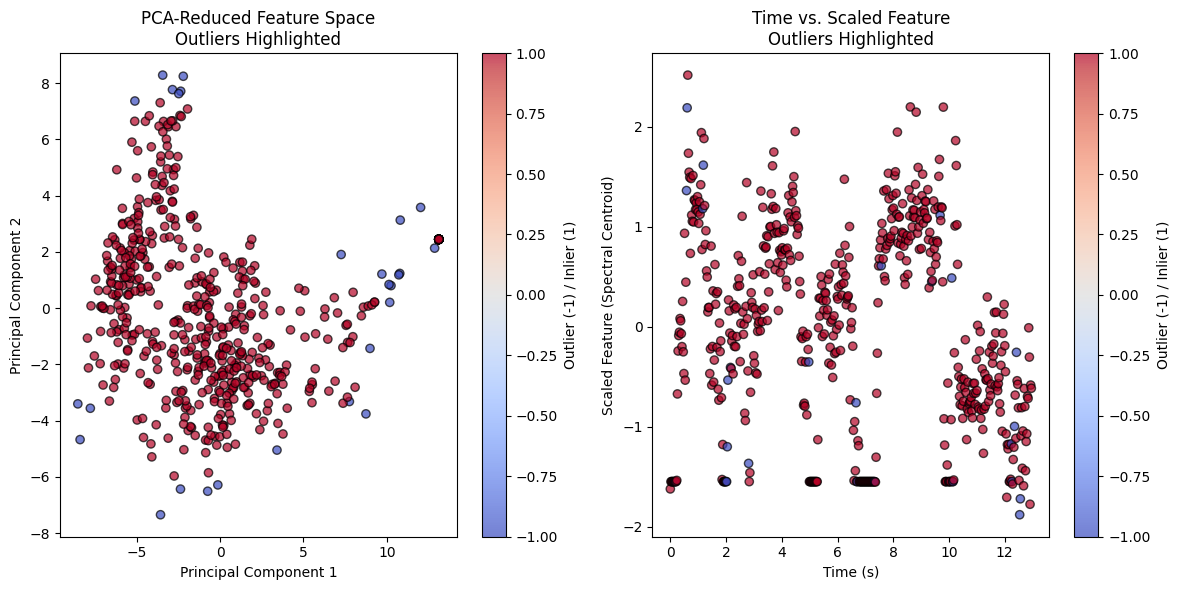

In [ ]:
# Multivariate Analysis

import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

audio_path = 'baby_cry.wav'
y, sr = librosa.load(audio_path)

# Framing of Audio Signals
frame_length = 2048
hop_length = 512
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).T
features = []


for frame in frames:
    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=frame, sr=sr).flatten()
    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=frame, sr=sr).flatten()
    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr).flatten()
    # Zero Crossing Rate
    zero_crossing = librosa.feature.zero_crossing_rate(frame).flatten()
    # MFCC
    mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=13).flatten()

    # Combine features
    feature_vector = np.concatenate([centroid, bandwidth, rolloff, zero_crossing, mfcc])
    features.append(feature_vector)

feature_matrix = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

# PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05)
outliers_pca = iso_forest.fit_predict(features_pca)

# Direct outlier detection without PCA
iso_forest_direct = IsolationForest(contamination=0.05)
outliers_direct = iso_forest_direct.fit_predict(features_scaled)


# Visualization for PCA-Reduced Feature Space
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=outliers_pca, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Feature Space\nOutliers Highlighted')
plt.colorbar(label='Outlier (-1) / Inlier (1)')

# Time vs. First Feature with Outliers for Direct Analysis
times = librosa.frames_to_time(np.arange(frames.shape[0]), sr=sr, hop_length=hop_length)
plt.subplot(1, 2, 2)
plt.scatter(times, features_scaled[:, 0], c=outliers_direct, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Scaled Feature (Spectral Centroid)')
plt.title('Time vs. Scaled Feature\nOutliers Highlighted')
plt.colorbar(label='Outlier (-1) / Inlier (1)')

plt.tight_layout()
plt.show()


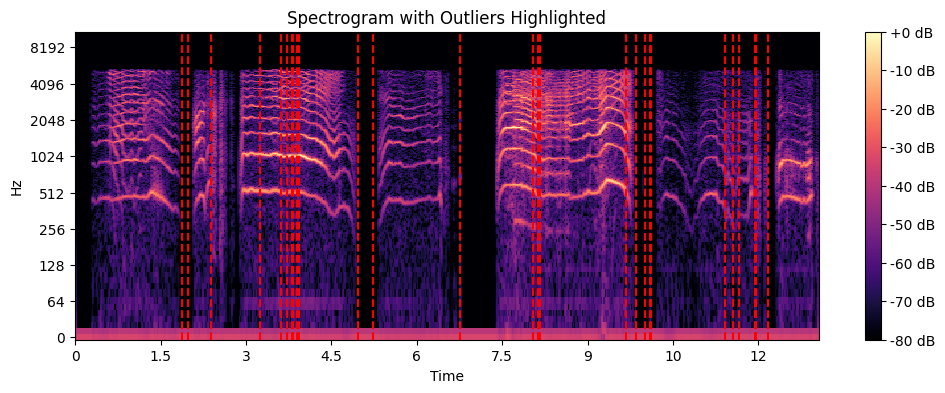

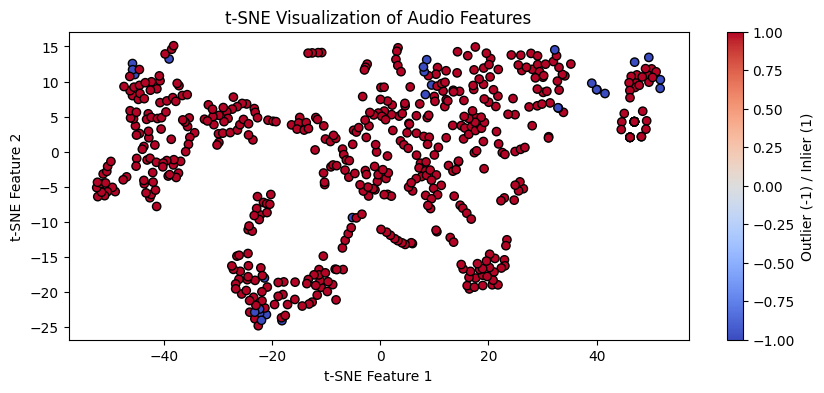

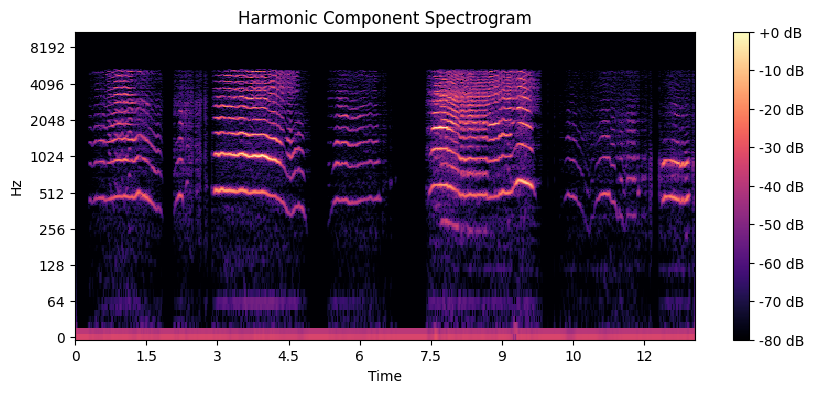

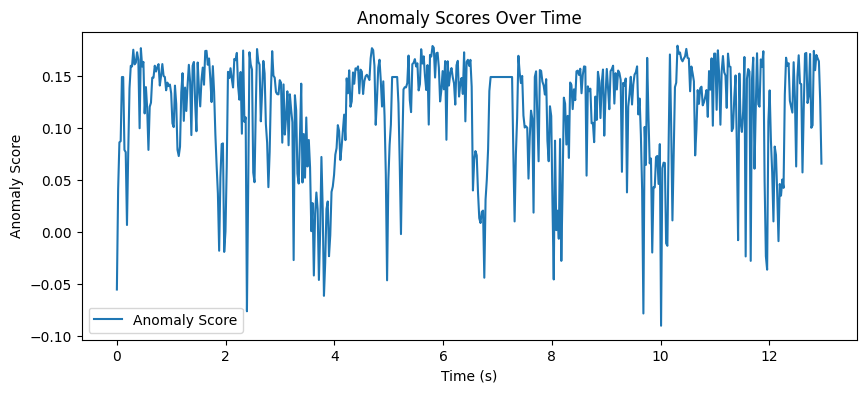

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

# Load the audio file
audio_path = 'baby_cry.wav'
y, sr = librosa.load(audio_path)

frame_length = 2048
hop_length = 512
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).T
features = []

# Feature extraction
for frame in frames:
    centroid = librosa.feature.spectral_centroid(y=frame, sr=sr).flatten()
    bandwidth = librosa.feature.spectral_bandwidth(y=frame, sr=sr).flatten()
    rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr).flatten()
    zero_crossing = librosa.feature.zero_crossing_rate(frame).flatten()
    mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=13).flatten()
    feature_vector = np.concatenate([centroid, bandwidth, rolloff, zero_crossing, mfcc])
    features.append(feature_vector)

feature_matrix = np.array(features)

# Scaling and PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05)
outliers_pca = iso_forest.fit_predict(features_pca)

# Visualization: Spectrogram with Outliers Highlighted
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Outliers Highlighted')
times = librosa.frames_to_time(np.arange(frames.shape[0]), sr=sr, hop_length=hop_length)
for time, outlier in zip(times, outliers_pca):
    if outlier == -1:
        plt.axvline(x=time, color='r', linestyle='--')
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features_scaled)
plt.figure(figsize=(10, 4))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=outliers_pca, cmap='coolwarm', edgecolor='k')
plt.title('t-SNE Visualization of Audio Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Outlier (-1) / Inlier (1)')
plt.show()

# Harmonic/Percussive Separation
y_harmonic, y_percussive = librosa.effects.hpss(y)
D_harmonic = librosa.amplitude_to_db(np.abs(librosa.stft(y_harmonic)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D_harmonic, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic Component Spectrogram')
plt.show()

# Anomaly Scores Visualization
anomaly_scores_pca = iso_forest.decision_function(features_pca)

plt.figure(figsize=(10, 4))
plt.plot(times, anomaly_scores_pca, label='Anomaly Score')  # Plotting anomaly scores computed on PCA-reduced data
plt.xlabel('Time (s)')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Scores Over Time')
plt.legend()
plt.show()
